In [108]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

#setting models to run on gpu
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In the code below, I'm generating a very small training set, to see how well the model will predict the target function

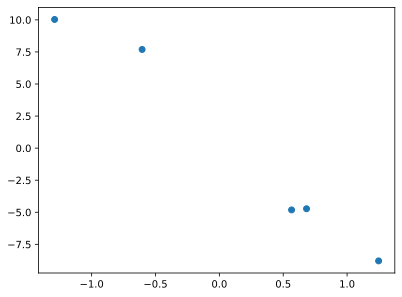

In [109]:
x_train = torch.rand(5)*4-2
y_train = x_train.pow(5) -10* x_train.pow(1) + 2*torch.rand(x_train.size())

plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)


In [110]:
def clean_target(x):
    return x.pow(5) -10* x.pow(1)+1
def target(x):
    return x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())


In [111]:
no_of_neurones = 2000

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=no_of_neurones),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1),
).to(device)


In [112]:
mse_loss = nn.MSELoss().to(device)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [113]:
def retrain(x_train: torch.Tensor, x_test: torch.Tensor, model: torch.nn.modules.container.Sequential, mean: np.ndarray, std: np.ndarray, differences: np.ndarray):
    #while the average std is greater than 0.2, add data to x_train and retrain model
    mean_vals = mean
    std_vals = std
    std_mean = np.mean(std)
    difference = np.abs(np.mean(differences))
    while(std_mean > 0.3):
        #* debugging
        # print(std_mean)
        # print(x_train.device, x_test.device)
        
        model = model.to(device) #sending model to gpu

        #forming df of x and std
        x_test_df = x_test[:, 0]
        df = pd.DataFrame({
            "x":x_test_df.to("cpu"),
            "std":differences
        }).sort_values("std", ascending=False)

        #creating tensor containing x values of greatest std
        x_to_add = df.iloc[:10, 0].sort_values().reset_index().drop(columns="index") #this is the data we want to add
        x_to_add = torch.unsqueeze(torch.tensor(x_to_add["x"].values), dim=1).to(device) #converting to tensor and sending it to gpu

        #* debugging
        x_train = torch.concat((x_train, x_to_add)).to(device)
        y_train = target(x_train.cpu()).to(device)

        #retraining model
        for step in range(2500):
            pre = model(x_train)
            mse = mse_loss(pre, y_train)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print('- MSE : %2.2f, KL : %2.2f, Cost : %2.2f' % (mse.item(), kl.item(), cost.item()))
        model = model.to("cpu")

        x_test = torch.unsqueeze(torch.linspace(-2, 2, 300), dim=1)
        y_test = target(x_test.cpu())

        #find the mean std values
        model_pred = np.array([model(x_test).data.numpy() for k in range(10000)])[:,:, 0].T
        mean_vals = np.array([model_pred[i].mean() for i in range(len(model_pred))])
        std_vals = np.array([model_pred[i].std() for i in range(len(model_pred))])
        difference = np.abs(np.mean(np.abs(mean_vals - y_test.data.numpy())/y_test.data.numpy())) 
        std_mean = np.mean(std_vals)
        print(f"- std_mean = {std_mean}")

        # if difference <= 0.3:
        #     return mean_vals, std_vals

    return mean_vals, std_vals


#I should check if the average standard deviation is high enough to make adding additional data worthwhile - best to do this beforehand

#! continue fixing this function


In [114]:
#training the model
for step in range(2500):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

print('- MSE : %2.2f, KL : %2.2f, Cost : %2.2f' % (mse.item(), kl.item(), cost.item()))

#moving model back to cpu for numpy to work with
model = model.to("cpu")

x_test = torch.unsqueeze(torch.linspace(-2, 2, 300), dim=1)
y_test = target(x_test)

model_predictions = np.array([model(x_test).data.numpy() for k in range(10000)])[:,:, 0].T
mean_values = np.array([model_predictions[i].mean() for i in range(len(model_predictions))])
std_values = np.array([model_predictions[i].std() for i in range(len(model_predictions))])

#find the mean percentrage diffrence between model_predictions and y_test
differences = np.abs(mean_values - y_test.data[:,0].numpy())/y_test[:,0].data.numpy()
# print(differences)

mean_values, std_values = retrain(x_train, x_test.to(device), model, mean_values, std_values, differences)


- MSE : 0.90, KL : 5.09, Cost : 0.95
- MSE : 1.48, KL : 7.57, Cost : 1.55
- std_mean = 0.3630717098712921
- MSE : 0.32, KL : 7.44, Cost : 0.40
- std_mean = 0.20283903181552887


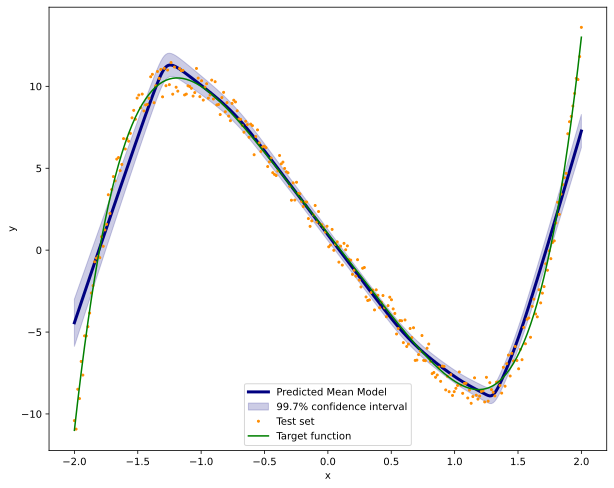

In [115]:
plt.figure(figsize=(10, 8))
plt.plot(x_test.data.numpy(), mean_values, color='navy',
         lw=3, label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0], mean_values-3.0*std_values, mean_values +
                 3.0*std_values, alpha=0.2, color='navy', label='99.7% confidence interval')
plt.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
         color='darkorange', markersize=4, label='Test set')
plt.plot(x_test.data.numpy(), clean_target(x_test).data.numpy(),
         color='green', markersize=4, label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.show()

torch.cuda.empty_cache()
del model

Clearly, the predicted model is off.

The wider the confidence interval, the greater the standard deviation for a given value of y at position x.

Therefore, find range of x where the greatest standard deviations exist and add that range of values to training data. Then, run the model again.

Okay, I've extracted the data I want to add to the training data to then retrain the model.

I now need to come up with a deviation threshold to constantly retrain the model until the average deviation falls below it.

Text(0, 0.5, 'y')

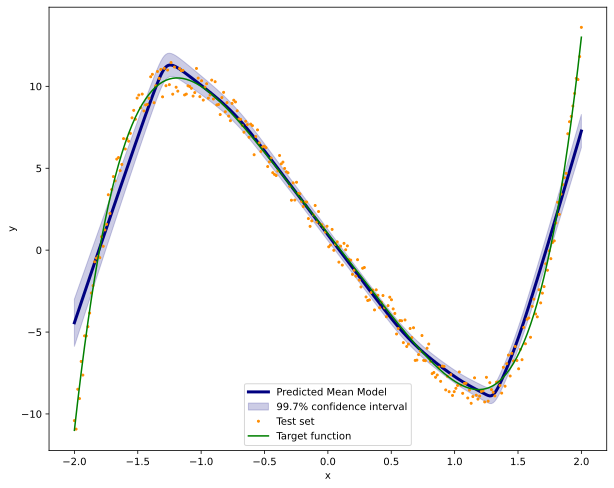

In [116]:
plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# plt.savefig(f'Graphs_epochs/neurons_{no_of_neurones}epochs_{n}.pdf')

#todo - complete intermediate ml on kaggle
#todo - complete intro to deep learning on kaggle
#todo - determine what parameters to measure for under- and overfitting
